문장이나 문서의 유사도를 구하는 작업은 자연어 처리의 주요 주제 중 하나입니다. 사람들이 인식하는 문서의 유사도는 주로 문서들 간에 동일한 단어 또는 비슷한 단어가 얼마나 공통적으로 많이 사용되었는지에 의존합니다. 기계도 마찬가지입니다. 기계가 계산하는 문서의 유사도의 성능은 각 문서의 단어들을 어떤 방법으로 수치화하여 표현했는지(DTM, Word2Vec 등), 문서 간의 단어들의 차이를 어떤 방법(유클리드 거리, 코사인 유사도 등)으로 계산했는지에 달려있습니다.

# 1. 코사인 유사도(Cosine Similaryty)

코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미합니다. 두 벡터의 방향이 완전히 동일한 경우에는 1의 값을 가지며, 90°의 각을 이루면 0, 180°로 반대의 방향을 가지면 -1의 값을 갖게 됩니다. 즉, 결국 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있습니다. 이를 직관적으로 이해하면 두 벡터가 가리키는 방향이 얼마나 유사한가를 의미합니다.

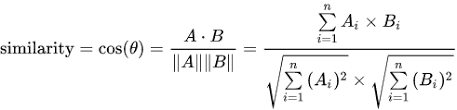

In [3]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A,B):
  return dot(A,B)/(norm(A)*norm(B))#외적/크기끼리 곱

doc1=np.array([0,1,1,1])
doc2=np.array([1,0,1,1])
doc3=np.array([2,0,2,2])

print('문서1과 문서2의 유사도:',cos_sim(doc1,doc2))
print('문서 1과 문서 3의 유사도:',cos_sim(doc1,doc3))
print('문서 2와 문서 3의 유사도 :',cos_sim(doc2,doc3))

문서1과 문서2의 유사도: 0.6666666666666667
문서 1과 문서 3의 유사도: 0.6666666666666667
문서 2와 문서 3의 유사도 : 1.0000000000000002


문서1과 문서2의 유사도와 문서1과 문서 3의 유사도가 같다는 점이 눈여겨볼만하다. 1은 두 벡터의 방향이 완전히 동일한 경우에 1이 나온다. 그리고 최댓값이다. 

문서 3은 문서 2에서 단지 모든 단어의 빈도수가 1씩 증가했을 뿐이다. 다시 말해 한문서 내의 모든 단어의 빈도수가 동일하게 증가하는 경우에는 기존의 문서와 코사인 유사도의 값이 1이라는 것이다. 
코사인 유사도는 유사도를 구할 떄 벡터의 방향(패턴)에 초점을 두므로 코사인 유사도는 문서의 길이가 다른 상황에서 비교적 공정한 비교를 할 수 있도록 도와준다. 

# 2. 유사도를 이용한 추천 시스템 구현하기

TF-IDF와 코사인 유사도만으로 영화의 줄거리에 기반해 영화를 추천하는 추천 시스템을 만들 수 있음. 

In [4]:
import os

os.environ['KAGGLE_USERNAME']='jiinpp'
os.environ['KAGGLE_KEY']="b06d525a9f66198051ccb648b091778a"

In [5]:
!kaggle datasets download -d rounakbanik/the-movies-dataset

 99% 225M/228M [00:02<00:00, 93.5MB/s]
100% 228M/228M [00:02<00:00, 90.7MB/s]


In [6]:
!unzip '*.zip'

Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

data=pd.read_csv('movies_metadata.csv',low_memory=False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

서 코사인 유사도에 사용할 데이터는 영화 제목에 해당하는 title 열과 줄거리에 해당하는 overview 열입니다. 좋아하는 영화를 입력하면, 해당 영화의 줄거리와 유사한 줄거리의 영화를 찾아서 추천하는 시스템을 만들 것입니다.

In [9]:
data=data.head(20000)

tf-idf를 연산할때 데이터에 NULL값이 들어있으면 에러가 발생한다. TF-IDF의 대상이 되는 data의 overview열에 결측값에 해당하는 NULL값이 있는지 확인한다. 

In [10]:
data['overview'].isna().sum()

135

In [11]:
#결측값 빈값으로 대체
data['overview']=data['overview'].fillna('')

In [12]:
#overview열에 대해 TFIDF 행렬을 구하자
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(data['overview'])
print(tfidf_matrix.shape)

(20000, 47487)


 20,000개의 영화를 표현하기 위해서 총 47,487개의 단어가 사용되었음을 의미합니다. 또는 47,847차원의 문서 벡터가 20,000개가 존재한다고도 표현할 수 있을 겁니다. 이제 20,000개의 문서 벡터에 대해서 상호 간의 코사인 유사도를 구합니다.

In [13]:
cosine_sim=cosine_similarity(tfidf_matrix,tfidf_matrix)
print('코사인 유사도 연산 결과:',cosine_sim.shape)

코사인 유사도 연산 결과: (20000, 20000)


코사인 유사도 연산 결과로는 20,000행 20,000열의 행렬을 얻습니다. 이는 20,000개의 각 문서 벡터(영화 줄거리 벡터)와 자기 자신을 포함한 20,000개의 문서 벡터 간의 유사도가 기록된 행렬입니다. 모든 20,000개 영화의 상호 유사도가 기록되어져 있습니다. 이제 기존 데이터프레임으로부터 영화의 타이틀을 key, 영화의 인덱스를 value로 하는 딕셔너리 title_to_index를 만들어둡니다.

In [14]:
#영화의 타이틀을 key, 영화의 인덱스를 value로 하는 딕셔너리 title_to_index
title_to_index=dict(zip(data['title'],data.index))

# 영화 제목 Father of the Bride Part II의 인덱스를 리턴
idx=title_to_index['Father of the Bride Part II']
print(idx)

4


선택한 영화의 제목을 입력하면 코사인 유사도를 통해 가장 overview가 유사한 10개의 영화를 찾아내는 함수를 만든다. 

In [18]:
def get_recommendations(title,cosine_sim=cosine_sim):
  #선택한 영화의 타이틀로부터 해당 영화의 인덱스를 받아온다. 
  idx=title_to_index[title]

  #해당 영화와 모든 영화와의 유사도를 가져온다. 
  sim_scores=list(enumerate(cosine_sim[idx]))

  #유사도에 따라 영화정렬
  sim_scores=sorted(sim_scores,key=lambda x:x[1],reverse=True)

  #가장 유사한 10개의 영화를 받아온다.
  sim_scores=sim_scores[1:11]

  #가장 유사한 10개의 영화의 인덱스를 얻는다.
  movie_indices=[idx[0] for idx in sim_scores]

  #가장 유사한 10개의 영화의 제목을 리턴
  return data['title'].iloc[movie_indices]



In [19]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

개소름